In [745]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt


# Getting the same results with train and train_manual_update
- Write torch.manual_seed(42) at the beginning of your notebook.
- Write torch.set_default_dtype(torch.double) at the beginning of your notebook to alleviate precision errors

In [746]:
SEED = 265
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)
rng = torch.Generator().manual_seed(SEED)

# Tasks
Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3
datasets: training, validation and test. Take a subset of these datasets
by keeping only 2 labels: cat and car

In [747]:
def filter_classes(dataset, keep_classes):
    # Filter out samples that do not belong to the classes we want to keep
    # Give them 0, 1 class labels
    new_samples = [(data, keep_classes.index(label)) for data, label in dataset if label in keep_classes]
    return new_samples

def load_cifar(train_val_split=0.9, data_path="data", preprocessor=None):
        
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.ToTensor()
        ])
    
    # Load CIFAR10 dataset training and validation sets
    cifar10_train_val = datasets.CIFAR10(
    data_path,      
    train=True,     
    download=True,
    transform=preprocessor
    )
    # Load CIFAR10 dataset test set
    cifar10_test = datasets.CIFAR10(
        data_path,
        train=False,
        download=True,
        transform=preprocessor
    )

    # Keep only classes 1 (automobile) and 3 (cat)
    keep_classes = [1, 3]
    cifar10_train_val = filter_classes(cifar10_train_val, keep_classes)
    cifar10_test = filter_classes(cifar10_test, keep_classes)

    # Split the training set into training and validation sets
    n_train_val = len(cifar10_train_val)
    n_train = int(n_train_val * (train_val_split))
    n_val = n_train_val - n_train 
    
    cifar10_train, cifar10_val = random_split(cifar10_train_val, lengths=[n_train, n_val], generator=rng)

    print(f"Number of training samples: {len(cifar10_train)}")
    print(f"Number of validation samples: {len(cifar10_val)}")
    print(f"Number of test samples: {len(cifar10_test)}")
   
    return cifar10_train, cifar10_val, cifar10_test


def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            # Forward pass by passing the images through the model
            outputs = model.forward(images)
            preds = torch.argmax(outputs, dim=1) #index of the maximum value in each of the 64 images
            bool_tensor = torch.eq(preds, labels)
            correct += torch.sum(bool_tensor).item()
            total += preds.shape[0]
            
    accuracy = correct/total
    return accuracy

In [748]:
cifar_train, cifar_val, cifar_test = load_cifar()

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 9000
Number of validation samples: 1000
Number of test samples: 2000


In [749]:
# print some images from the cifar_train dataset and their corresponding labels
# show a specified number (int pictures) of images of each class
def show_images(dataset, pictures):
    fig, axs = plt.subplots(2, pictures, figsize=(15, 5))
    auto_count = 0
    cat_count = 0
    i = 0
    while auto_count < pictures or cat_count < pictures:
        img, label = dataset[i]
        if label == 0 and auto_count < pictures:
            axs[0, auto_count].imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
            axs[0, auto_count].set_title("automobile")
            axs[0, auto_count].axis("off")
            auto_count += 1
        elif label == 1 and cat_count < pictures:
            axs[1, cat_count].imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
            axs[1, cat_count].set_title("cat")
            axs[1, cat_count].axis("off")
            cat_count += 1
        i += 1
    plt.show()

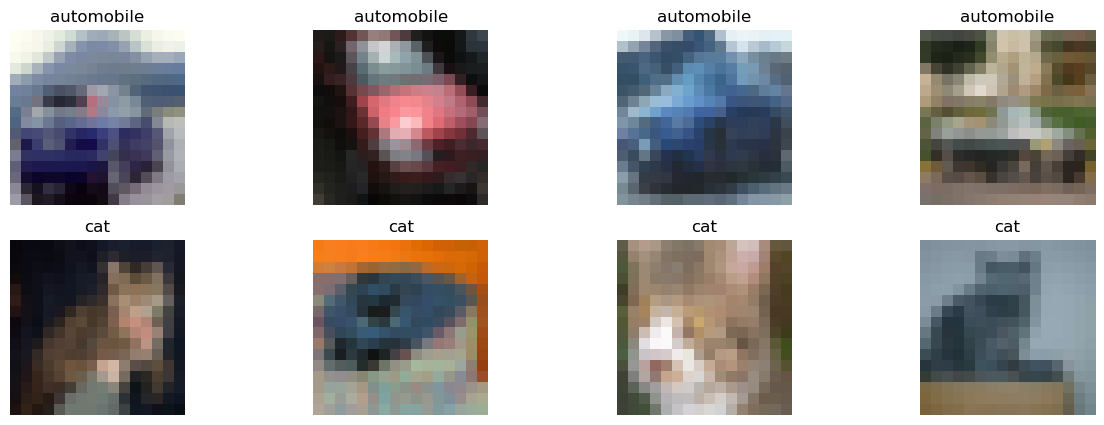

In [750]:
show_images(cifar_train, 4)

In [751]:
# Compute the mean and standard deviation of the training set with the two classes
def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)  # Number of images in batch
        images = images.view(batch_samples, images.shape[1], -1)  # Flatten each image
        mean += images.mean(dim=[0, 2]) * batch_samples
        std += images.std(dim=[0, 2]) * batch_samples
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

mean, std = compute_mean_std(cifar_train)

print(f"Computed mean: {mean}")
print(f"Computed std: {std}")


Computed mean: tensor([0.4839, 0.4558, 0.4316])
Computed std: tensor([0.2421, 0.2388, 0.2475])


In [752]:
# Define normalization transform using computed mean and std
normalize_transform = transforms.Normalize(mean.tolist(), std.tolist())

# Apply normalization to each dataset
def normalize_dataset(dataset):
    return [(normalize_transform(image), label) for image, label in dataset]

cifar_train = normalize_dataset(cifar_train)
cifar_val = normalize_dataset(cifar_val)
cifar_test = normalize_dataset(cifar_test)


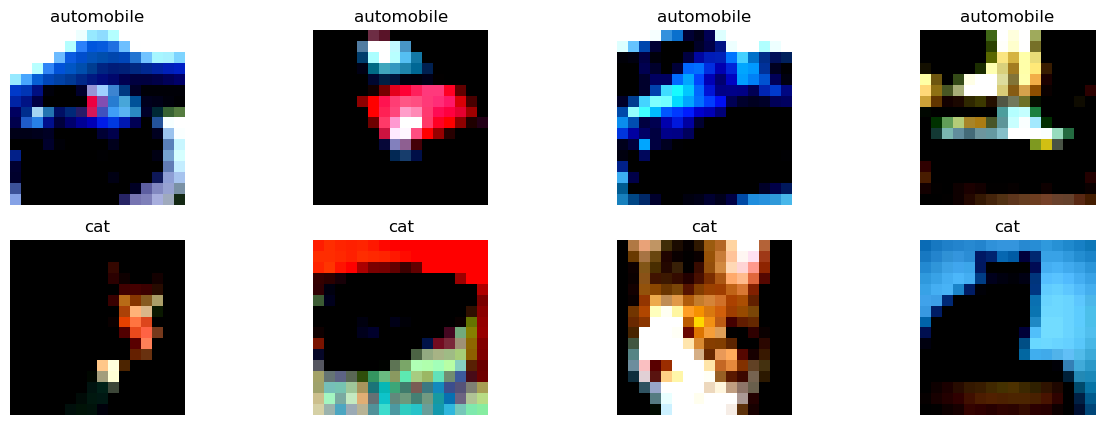

In [753]:
#show images from the cifar_train dataset after normalization
show_images(cifar_train, 4)

Write a MyMLP class that implements a MLP in PyTorch (so only fully
connected layers) such that:
    
    - The input dimension is 768(= 16 ∗ 16 ∗ 3) and the output dimension is 2 (for the 2 classes).
    - The hidden layers have respectively 128 and 32 hidden units.
    - All activation functions are ReLU. The last layer has no activation function since the cross-entropy loss already includes a softmax activation function.

In [754]:
class MyMLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            torch.nn.Linear(16*16*3, 128), 
            torch.nn.ReLU(), 
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 2)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


Write a train(n_epochs, optimizer, model, loss_fn, train_loader) function that trains model for n_epochs epochs given an optimizer optimizer, a loss function loss_fn and a dataloader train_loader.

In [755]:
def train(optimizer, model, loss_fn, train_loader, n_epochs = 10):
    train_losses = []
    print("--------- Using Pytorch's SGD ---------")
    
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device=('cpu'), dtype=torch.double)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            optimizer.zero_grad()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        if (epoch) == 1 or (epoch) % 5 == 0:
            now = datetime.now()
            print(f"{now}  (manual train) | Epoch {epoch} / {n_epochs} | Training Loss: {train_loss:.5f}")

    return train_losses


Write a similar function train manual_update that has no optimizer parameter, but a learning rate lr parameter instead and that manually updates each trainable parameter of model using equation (2). Do not forget to zero out all gradients after each iteration. 

Train 2 instances of MyMLP, one using train and the other using train_manual_update (use the same parameter values for both models). Compare their respective training losses. To get exactly the same results with both functions, see section 3.3

In [756]:
def train_manual_update(model, loss_fn, train_loader, lr=1e-2, momentum_coeff=0., weight_decay=0., n_epochs = 30):
    train_losses = []
    print("--------- Using manual update ----------")
    
    velocity = {p: torch.zeros_like(p) for p in model.parameters()}

    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device='cpu', dtype=torch.double)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    grad_with_decay = p.grad + weight_decay * p.data
                    velocity[p] = momentum_coeff * velocity[p] - lr * grad_with_decay
                    p.data += velocity[p]

            train_loss += loss.item()
            
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        if (epoch) == 1 or (epoch) % 5 == 0:
            now = datetime.now()
            print(f"{now}  (manual train) | Epoch {epoch} / {n_epochs} | Training Loss: {train_loss:.5f}")
        
    return train_losses
    

In [757]:
batch_size = 256

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=0)

loss_fn = nn.CrossEntropyLoss()

In [758]:
def train_and_validate(model, model_manuel, train_loader, val_loader, n_epochs=30, loss_fn=loss_fn, lr=0.01, weight_decay=0, momentum_coeff=0.):
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum_coeff)
    accuracies = {}
    
    train_losses = train(optimizer, model, loss_fn, train_loader, n_epochs)
    train_accuracy = compute_accuracy(model, train_loader)
    val_accuracy = compute_accuracy(model, val_loader)

    print()
    print("--- Accuracies ---")
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print()

    train_losses_manuel = train_manual_update(model_manuel, loss_fn, train_loader, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs, momentum_coeff=momentum_coeff)
    train_accuracy_manuel = compute_accuracy(model_manuel, train_loader)
    val_accuracy_manuel = compute_accuracy(model_manuel, val_loader)
    print()
    print("--- Accuracies ---")
    print(f"Train accuracy (manual): {train_accuracy_manuel:.4f}")
    print(f"Validation accuracy (manual): {val_accuracy_manuel:.4f}")

    accuracies['train'] = train_accuracy
    accuracies['val'] = val_accuracy
    accuracies['train_manuel'] = train_accuracy_manuel
    accuracies['val_manuel'] = val_accuracy_manuel

    return train_losses, train_losses_manuel, accuracies


In [759]:
results = []
accuracies = {}

In [760]:
torch.manual_seed(SEED)
model1_1 = MyMLP()
torch.manual_seed(SEED)
model1_2 = MyMLP()

train_losses_1, train_losses_manuel_1, accuracies1 = train_and_validate(model1_1, model1_2, train_loader, val_loader)
results.append((train_losses_1, train_losses_manuel_1))

accuracies[model1_1] = accuracies1 

--------- Using Pytorch's SGD ---------
2025-02-21 12:30:40.033917  (manual train) | Epoch 1 / 30 | Training Loss: 0.67848
2025-02-21 12:30:40.487117  (manual train) | Epoch 5 / 30 | Training Loss: 0.55593
2025-02-21 12:30:40.964999  (manual train) | Epoch 10 / 30 | Training Loss: 0.43637
2025-02-21 12:30:41.491472  (manual train) | Epoch 15 / 30 | Training Loss: 0.37139
2025-02-21 12:30:41.970237  (manual train) | Epoch 20 / 30 | Training Loss: 0.32341
2025-02-21 12:30:42.432077  (manual train) | Epoch 25 / 30 | Training Loss: 0.28893
2025-02-21 12:30:42.904799  (manual train) | Epoch 30 / 30 | Training Loss: 0.26306

--- Accuracies ---
Train accuracy: 0.8970
Validation accuracy: 0.8850

--------- Using manual update ----------
2025-02-21 12:30:43.075556  (manual train) | Epoch 1 / 30 | Training Loss: 0.67848
2025-02-21 12:30:43.589020  (manual train) | Epoch 5 / 30 | Training Loss: 0.55593
2025-02-21 12:30:44.228321  (manual train) | Epoch 10 / 30 | Training Loss: 0.43637
2025-02-21 

In [761]:
torch.manual_seed(SEED)
model2_1 = MyMLP()
torch.manual_seed(SEED)
model2_2 = MyMLP()

train_losses_2, train_losses_manuel_2, accuracies2= train_and_validate(model2_1, model2_2, train_loader, val_loader, weight_decay=0.01,  lr=0.01)
results.append((train_losses_2, train_losses_manuel_2))
accuracies[model2_1] = accuracies2

--------- Using Pytorch's SGD ---------
2025-02-21 12:30:46.991027  (manual train) | Epoch 1 / 30 | Training Loss: 0.67858
2025-02-21 12:30:47.404788  (manual train) | Epoch 5 / 30 | Training Loss: 0.55950
2025-02-21 12:30:47.898027  (manual train) | Epoch 10 / 30 | Training Loss: 0.44216
2025-02-21 12:30:48.389748  (manual train) | Epoch 15 / 30 | Training Loss: 0.37867
2025-02-21 12:30:48.875533  (manual train) | Epoch 20 / 30 | Training Loss: 0.33183
2025-02-21 12:30:49.369992  (manual train) | Epoch 25 / 30 | Training Loss: 0.29787
2025-02-21 12:30:49.854375  (manual train) | Epoch 30 / 30 | Training Loss: 0.27279

--- Accuracies ---
Train accuracy: 0.8939
Validation accuracy: 0.8850

--------- Using manual update ----------
2025-02-21 12:30:50.038453  (manual train) | Epoch 1 / 30 | Training Loss: 0.67858
2025-02-21 12:30:50.553177  (manual train) | Epoch 5 / 30 | Training Loss: 0.55950
2025-02-21 12:30:51.194635  (manual train) | Epoch 10 / 30 | Training Loss: 0.44216
2025-02-21 

In [762]:
torch.manual_seed(SEED)
model3_1 = MyMLP()
torch.manual_seed(SEED)
model3_2 = MyMLP()

train_losses_3, train_losses_manuel_3, accuracies3 = train_and_validate(model3_1, model3_2, train_loader, val_loader, momentum_coeff=0.85,  lr=0.01)
results.append((train_losses_3, train_losses_manuel_3))
accuracies[model3_1] = accuracies3


--------- Using Pytorch's SGD ---------
2025-02-21 12:30:53.887772  (manual train) | Epoch 1 / 30 | Training Loss: 0.62979
2025-02-21 12:30:54.312127  (manual train) | Epoch 5 / 30 | Training Loss: 0.29358
2025-02-21 12:30:54.820621  (manual train) | Epoch 10 / 30 | Training Loss: 0.19444
2025-02-21 12:30:55.336485  (manual train) | Epoch 15 / 30 | Training Loss: 0.13618
2025-02-21 12:30:55.846399  (manual train) | Epoch 20 / 30 | Training Loss: 0.09612
2025-02-21 12:30:56.376342  (manual train) | Epoch 25 / 30 | Training Loss: 0.06564
2025-02-21 12:30:56.901953  (manual train) | Epoch 30 / 30 | Training Loss: 0.04933

--- Accuracies ---
Train accuracy: 0.9821
Validation accuracy: 0.9190

--------- Using manual update ----------
2025-02-21 12:30:57.078658  (manual train) | Epoch 1 / 30 | Training Loss: 0.62979
2025-02-21 12:30:57.569568  (manual train) | Epoch 5 / 30 | Training Loss: 0.29358
2025-02-21 12:30:58.190000  (manual train) | Epoch 10 / 30 | Training Loss: 0.19444
2025-02-21 

In [763]:
torch.manual_seed(SEED)
model4_1 = MyMLP()
torch.manual_seed(SEED)
model4_2 = MyMLP()

train_losses_4, train_losses_manuel_4, accuracies4 = train_and_validate(model4_1, model4_2, train_loader, val_loader, momentum_coeff=0.85, weight_decay=0.001,  lr=0.01)
results.append((train_losses_4, train_losses_manuel_4))
accuracies[model4_1] = accuracies4

--------- Using Pytorch's SGD ---------
2025-02-21 12:31:00.818847  (manual train) | Epoch 1 / 30 | Training Loss: 0.62993
2025-02-21 12:31:01.260738  (manual train) | Epoch 5 / 30 | Training Loss: 0.29406
2025-02-21 12:31:01.803477  (manual train) | Epoch 10 / 30 | Training Loss: 0.19597
2025-02-21 12:31:02.341589  (manual train) | Epoch 15 / 30 | Training Loss: 0.13781
2025-02-21 12:31:02.898242  (manual train) | Epoch 20 / 30 | Training Loss: 0.09767
2025-02-21 12:31:03.440528  (manual train) | Epoch 25 / 30 | Training Loss: 0.06673
2025-02-21 12:31:03.983580  (manual train) | Epoch 30 / 30 | Training Loss: 0.04405

--- Accuracies ---
Train accuracy: 0.9831
Validation accuracy: 0.9210

--------- Using manual update ----------
2025-02-21 12:31:04.167544  (manual train) | Epoch 1 / 30 | Training Loss: 0.62993
2025-02-21 12:31:04.681876  (manual train) | Epoch 5 / 30 | Training Loss: 0.29406
2025-02-21 12:31:05.308159  (manual train) | Epoch 10 / 30 | Training Loss: 0.19597
2025-02-21 

In [764]:
torch.manual_seed(SEED)
model5_1 = MyMLP()
torch.manual_seed(SEED)
model5_2 = MyMLP()

train_losses_5, train_losses_manuel_5, accuracies5 = train_and_validate(model5_1, model5_2, train_loader, val_loader, momentum_coeff=0.85, weight_decay=0.001,  lr=0.05)
results.append((train_losses_5, train_losses_manuel_5))
accuracies[model5_1] = accuracies5

--------- Using Pytorch's SGD ---------
2025-02-21 12:31:08.014373  (manual train) | Epoch 1 / 30 | Training Loss: 0.50084
2025-02-21 12:31:08.491686  (manual train) | Epoch 5 / 30 | Training Loss: 0.20938
2025-02-21 12:31:09.003100  (manual train) | Epoch 10 / 30 | Training Loss: 0.12418
2025-02-21 12:31:09.522394  (manual train) | Epoch 15 / 30 | Training Loss: 0.08710
2025-02-21 12:31:10.052198  (manual train) | Epoch 20 / 30 | Training Loss: 0.11344
2025-02-21 12:31:10.580780  (manual train) | Epoch 25 / 30 | Training Loss: 0.07383
2025-02-21 12:31:11.100569  (manual train) | Epoch 30 / 30 | Training Loss: 0.03130

--- Accuracies ---
Train accuracy: 0.9763
Validation accuracy: 0.9130

--------- Using manual update ----------
2025-02-21 12:31:11.275073  (manual train) | Epoch 1 / 30 | Training Loss: 0.50084
2025-02-21 12:31:11.763172  (manual train) | Epoch 5 / 30 | Training Loss: 0.20938
2025-02-21 12:31:12.381079  (manual train) | Epoch 10 / 30 | Training Loss: 0.12418
2025-02-21 

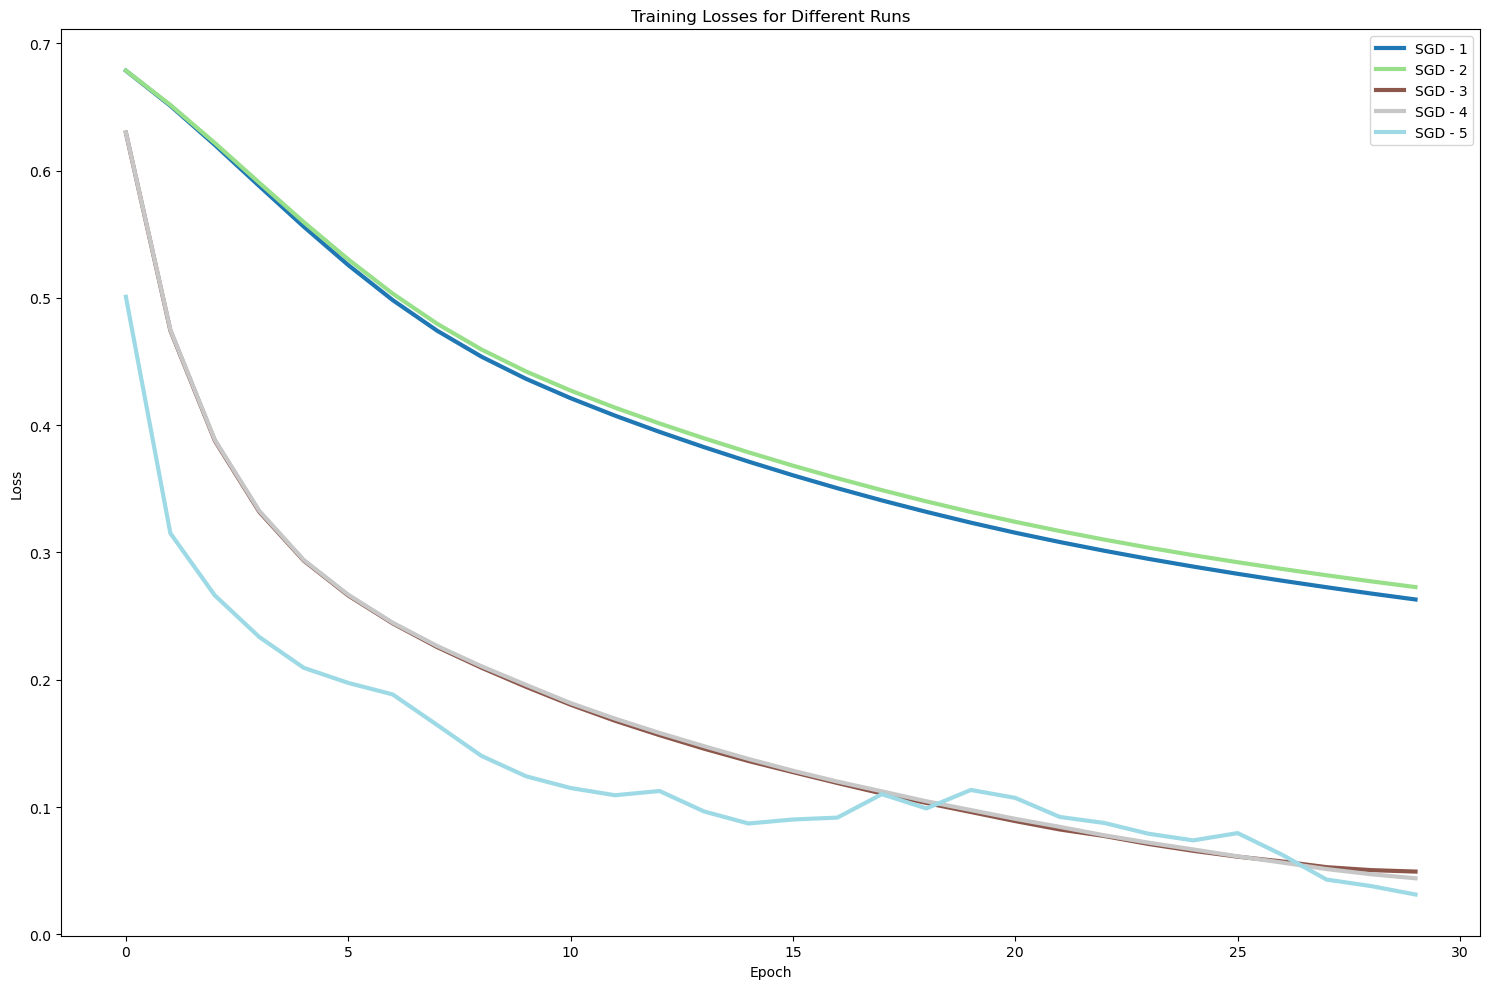

In [765]:
fig, ax = plt.subplots(figsize=(15, 10))
colors = plt.cm.tab20(np.linspace(0, 1, len(results)))  # Use a colormap with more distinct colors

for i in range(len(results)):
    train_losses, _ = results[i]
    ax.plot(train_losses, label=f"SGD - {i+1}", linewidth=3, color=colors[i])

ax.set_title("Training Losses for Different Runs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

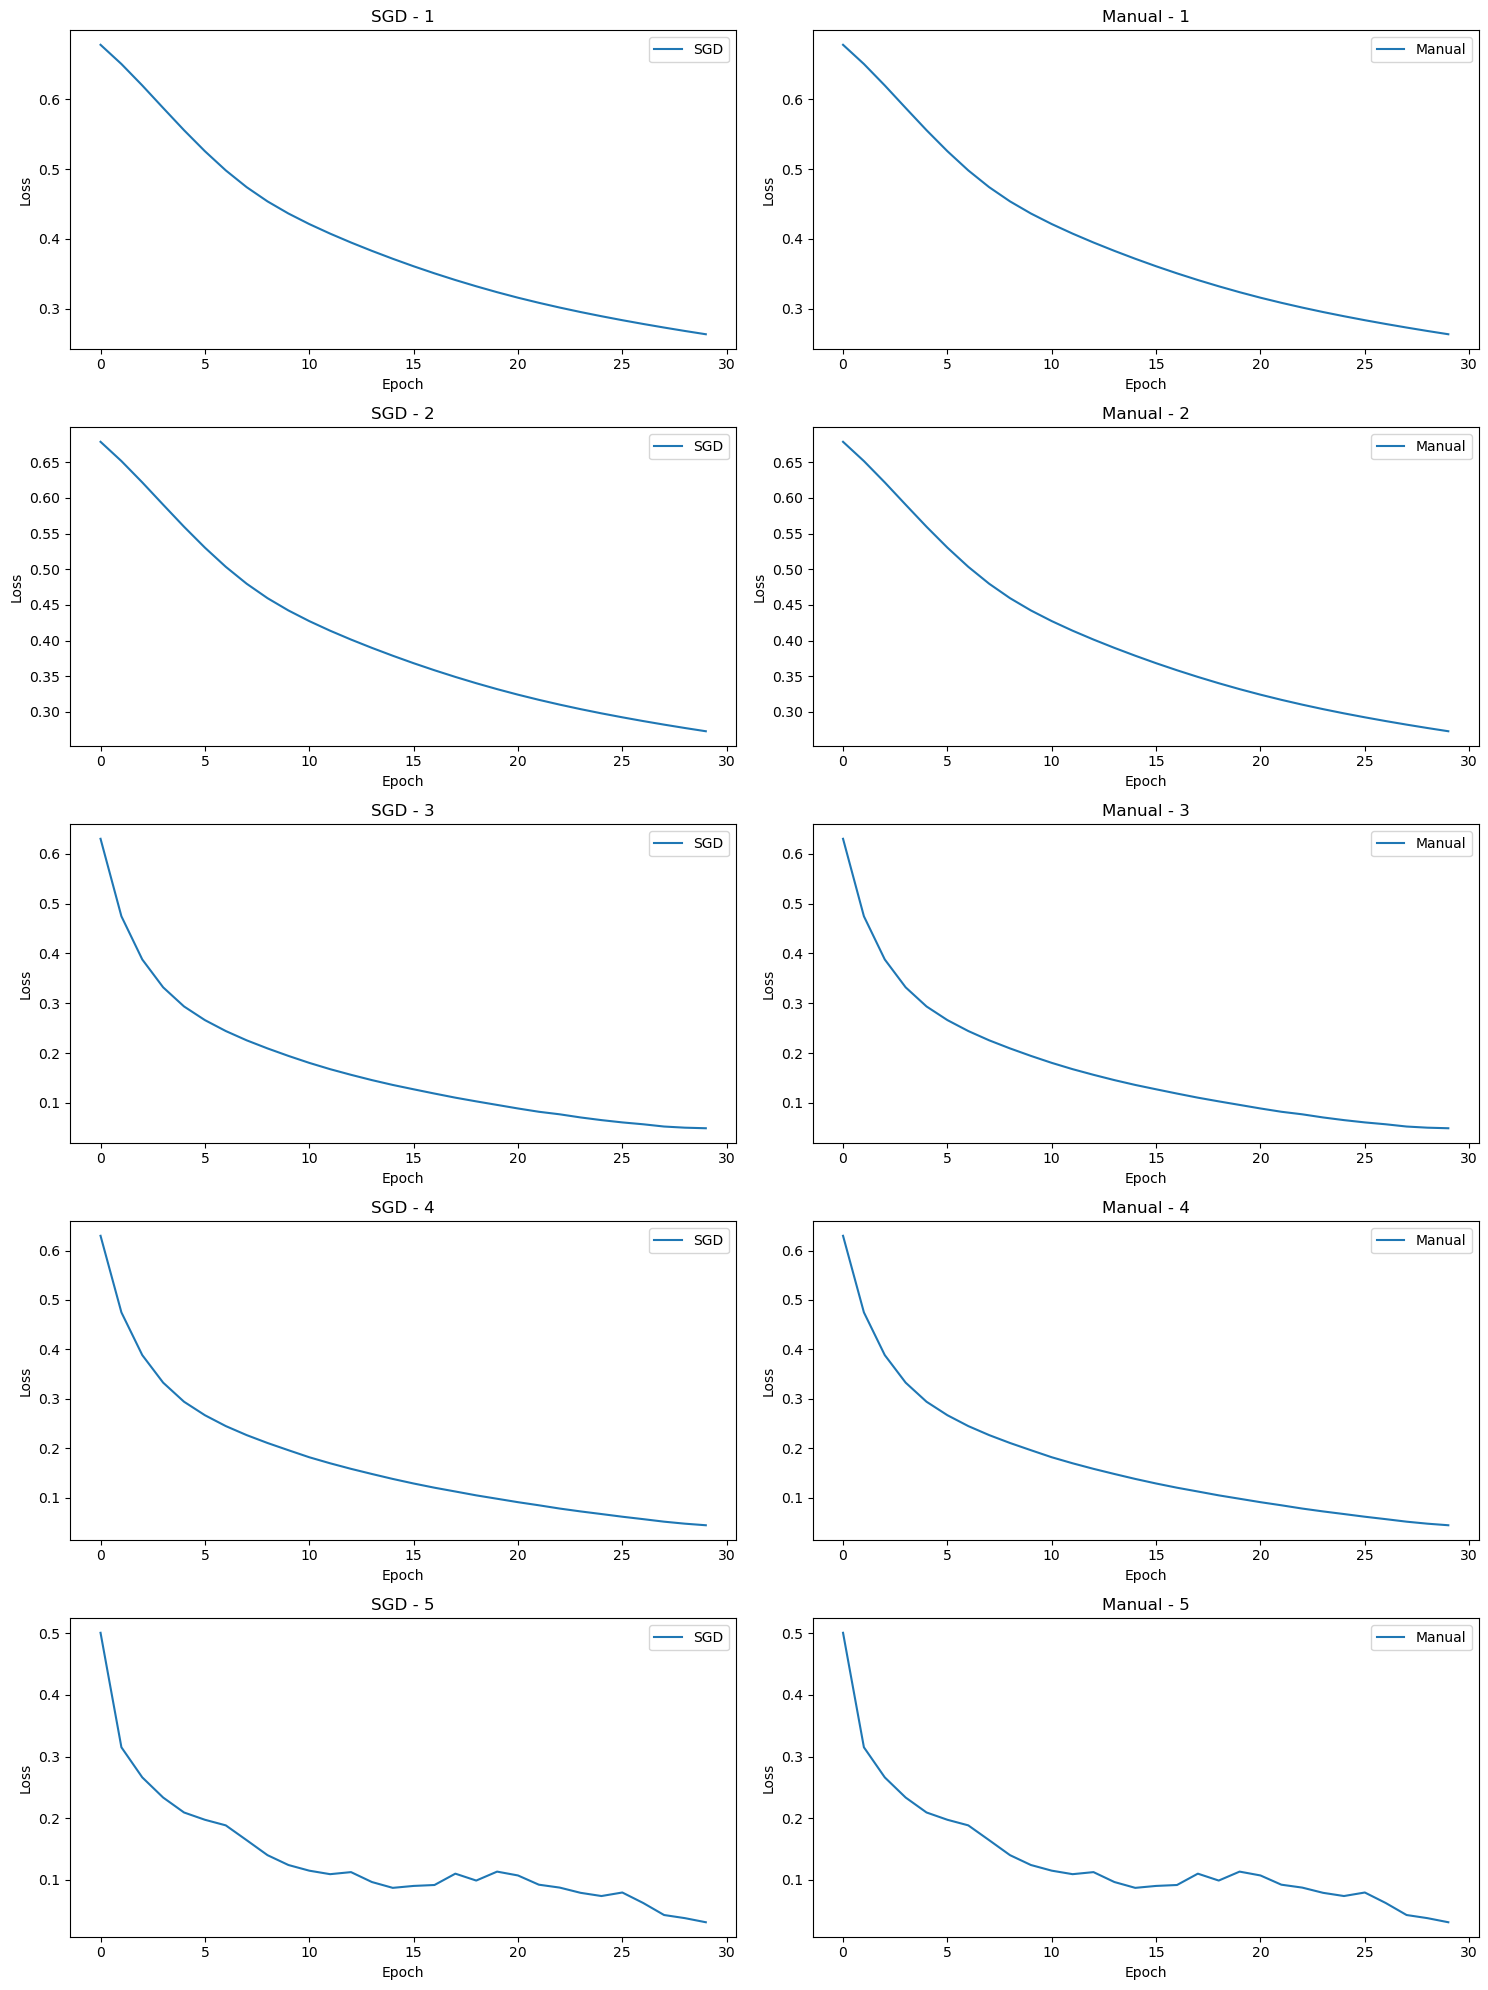

In [766]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(len(results)):
    train_losses, train_losses_manuel = results[i]
    axs[i, 0].plot(train_losses, label="SGD")
    axs[i, 0].set_title(f"SGD - {i+1}")
    axs[i, 0].set_xlabel("Epoch")
    axs[i, 0].set_ylabel("Loss")
    axs[i, 0].legend()

    axs[i, 1].plot(train_losses_manuel, label="Manual")
    axs[i, 1].set_title(f"Manual - {i+1}")
    axs[i, 1].set_xlabel("Epoch")
    axs[i, 1].set_ylabel("Loss")
    axs[i, 1].legend()

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

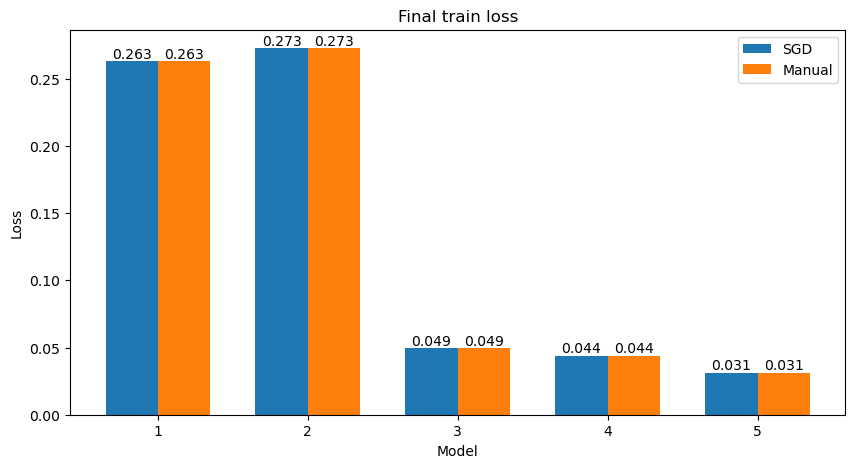

In [767]:
# plot the last train_loss from each model in a single plot bar
train_losses = [train_losses_1[-1], train_losses_2[-1], train_losses_3[-1], train_losses_4[-1], train_losses_5[-1]]
train_losses_manuel = [train_losses_manuel_1[-1], train_losses_manuel_2[-1], train_losses_manuel_3[-1], train_losses_manuel_4[-1], train_losses_manuel_5[-1]]
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
index = np.arange(len(train_losses))
bars1 = ax.bar(index, train_losses, bar_width, label="SGD")
bars2 = ax.bar(index + bar_width, train_losses_manuel, bar_width, label="Manual")

# Add values above the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

ax.set_xlabel("Model")
ax.set_ylabel("Loss")
ax.set_title("Final train loss")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f"{i+1}" for i in range(len(train_losses))])
ax.legend()
plt.show()

Model 1 - Train Accuracy: 0.8970
Model 1 - Validation Accuracy: 0.8850

Model 2 - Train Accuracy: 0.8939
Model 2 - Validation Accuracy: 0.8850

Model 3 - Train Accuracy: 0.9821
Model 3 - Validation Accuracy: 0.9190

Model 4 - Train Accuracy: 0.9831
Model 4 - Validation Accuracy: 0.9210

Model 5 - Train Accuracy: 0.9763
Model 5 - Validation Accuracy: 0.9130



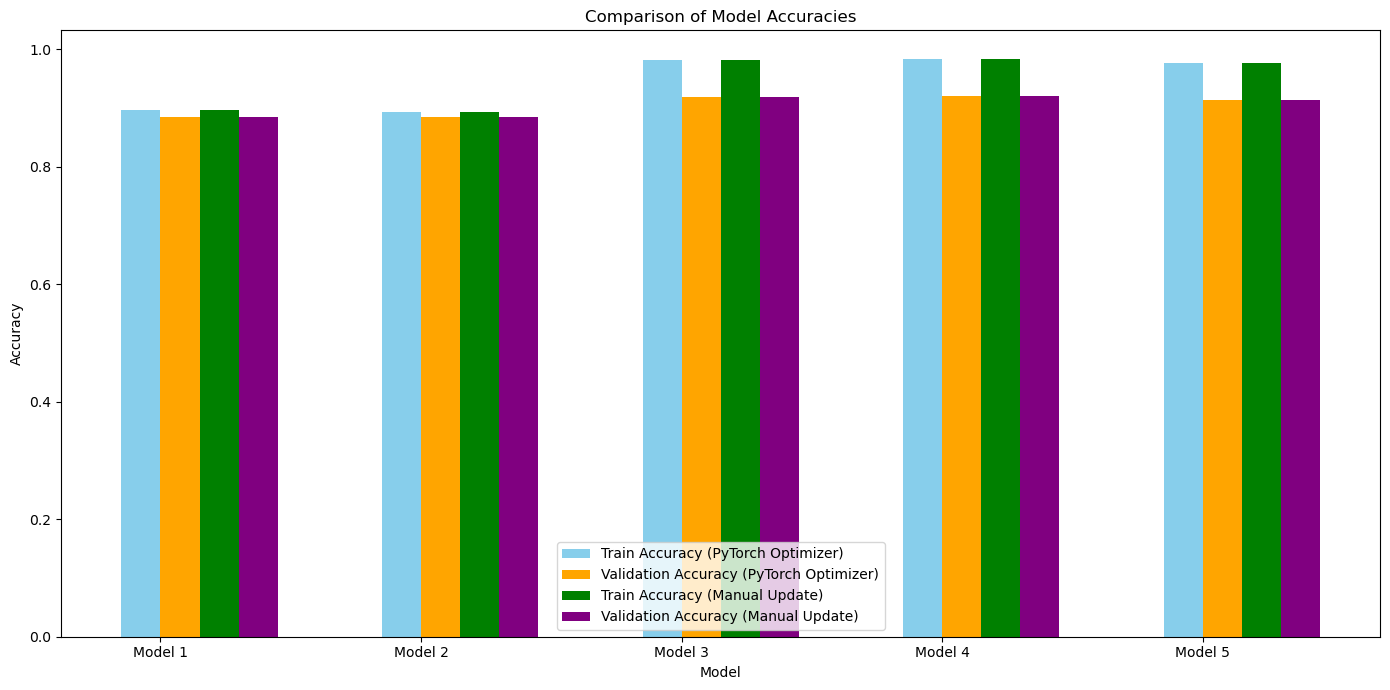

In [768]:
model_names = list(accuracies.keys())

model_names_string = []
for i in range(len(model_names)):
    model_names_string.append(f"Model {i+1}")

# Extract the accuracies
train_acc = [accuracies[model]['train'] for model in model_names]
val_acc = [accuracies[model]['val'] for model in model_names]
train_acc_manual = [accuracies[model]['train_manuel'] for model in model_names]
val_acc_manual = [accuracies[model]['val_manuel'] for model in model_names]

for i in range(len(model_names)):
    print(f"Model {i+1} - Train Accuracy: {train_acc[i]:.4f}")
    print(f"Model {i+1} - Validation Accuracy: {val_acc[i]:.4f}")
    print()

# Create a bar plot
plt.figure(figsize=(14, 7))

# Bar width and positions
bar_width = 0.15
x = range(len(model_names))

# Plotting the bars
plt.bar(x, train_acc, bar_width, label="Train Accuracy (PyTorch Optimizer)", color='skyblue')
plt.bar([p + bar_width for p in x], val_acc, bar_width, label="Validation Accuracy (PyTorch Optimizer)", color='orange')
# If you want to include manual update accuracies, you can uncomment these lines
plt.bar([p + bar_width * 2 for p in x], train_acc_manual, bar_width, label="Train Accuracy (Manual Update)", color='green')
plt.bar([p + bar_width * 3 for p in x], val_acc_manual, bar_width, label="Validation Accuracy (Manual Update)", color='purple')

# Set labels, title, and legend
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.xticks([p + bar_width / 2 for p in x], model_names_string)
plt.legend()
plt.tight_layout()

plt.show()


In [769]:
best_model = max(accuracies, key=lambda x: accuracies[x]['val'])
# get the index of the best model
best_model_name = model_names_string[model_names.index(best_model)]
print(f"Best model: {best_model_name} ")

# save the accuracies train and validation of the best model
best_model_train_acc = accuracies[best_model]['train']
best_model_val_acc = accuracies[best_model]['val']



Best model: Model 4 


In [770]:
# test the best model
test_accuracy = compute_accuracy(best_model, test_loader)
print(f"Test accuracy of the best model: {test_accuracy:.4f}")


Test accuracy of the best model: 0.9170


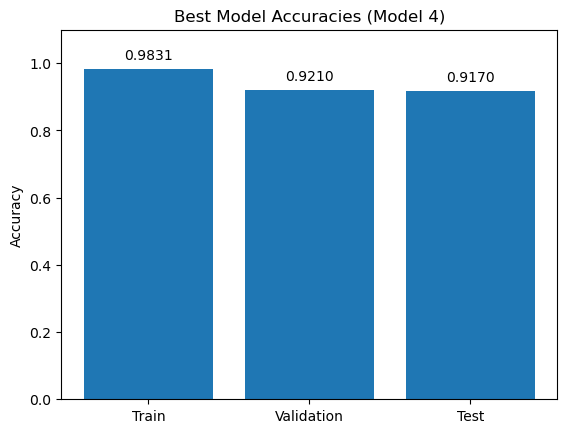

In [771]:
# Get the training, validation, and test accuracies of the best model and plot them
accuracies = [best_model_train_acc, best_model_val_acc, test_accuracy]
labels = ['Train', 'Validation', 'Test']

plt.bar(labels, accuracies)
plt.ylim(0, 1.1)

for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.02, f'{accuracy:.4f}', ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title(f'Best Model Accuracies ({best_model_name})')
plt.show()


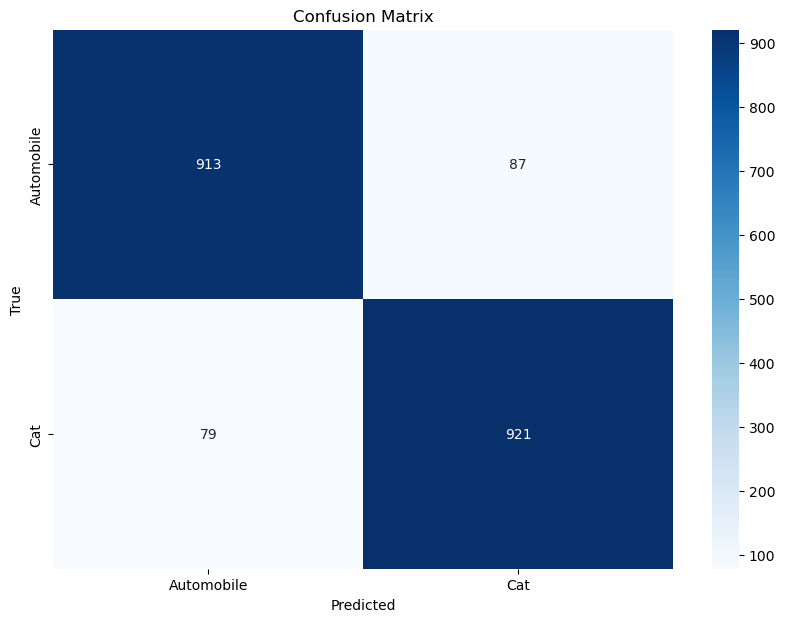

In [772]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions and true labels
all_preds = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Automobile', 'Cat'], yticklabels=['Automobile', 'Cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
